# Import the needed libraries

In [139]:
# Packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import ticker
import seaborn as sns
import joypy
import category_encoders as ce
import collections
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
import random
from collections import defaultdict
import time
import warnings
warnings.filterwarnings("ignore")

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

# Data Partition
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Data Normalization
from sklearn.preprocessing import MinMaxScaler

# Wrapper Methods
from sklearn.feature_selection import RFE

# Logistic Regression
from sklearn.linear_model import LogisticRegression

# Other models from sklearn
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import SGDClassifier, Perceptron, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Model selection with grid search
from sklearn.model_selection import GridSearchCV

# Extract the data

In [140]:
# extract the data of the first sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_task_execution = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx')
ds_task_execution_original = ds_task_execution.copy()

In [141]:
# extract the data of the second sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_user_info = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=1)
ds_user_info_original = ds_user_info.copy()

In [142]:
# extract the data of the third sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_specific_request = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=2)
ds_specific_request_original = ds_specific_request.copy()

In [143]:
# extract the data of the fourth sheet of Case4_UNL-IMS - Data - delivery v2.xlsx
ds_rejections = pd.read_excel('Case4_UNL-IMS - Data - delivery v2.xlsx', sheet_name=3)
ds_rejections_original = ds_rejections.copy()

# 1. Data Exploration and Preparation

### 1.1. Task Execution 

In [144]:
ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Actvity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299


In [145]:
ds_task_execution.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209017 entries, 0 to 209016
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Task Id                   209017 non-null  int64  
 1   Request Identifier        209017 non-null  int64  
 2   Task arrival date         209017 non-null  object 
 3   Task capture date         209017 non-null  object 
 4   Task execution end date   209017 non-null  object 
 5   Task predicted end date   163232 non-null  object 
 6   Actvity ID                209017 non-null  int64  
 7   Task Executer             188888 non-null  float64
 8   Task executer department  181887 non-null  float64
 9   Task Type                 209017 non-null  object 
 10  Action                    124576 non-null  object 
 11  idBPMApplicationAction    209017 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 19.1+ MB


In [146]:
# Rename the column Actvity ID to Activity ID
ds_task_execution.rename(columns={'Actvity ID': 'Activity ID'}, inplace=True)

In [147]:
# Check for nulls
ds_task_execution.isnull().sum()

Task Id                         0
Request Identifier              0
Task arrival date               0
Task capture date               0
Task execution end date         0
Task predicted end date     45785
Activity ID                     0
Task Executer               20129
Task executer department    27130
Task Type                       0
Action                      84441
idBPMApplicationAction          0
dtype: int64

In [148]:
# os nulls da Task predicted end date são todos do task type 'initial request', acho q era suposto

In [149]:
# Check for duplicates
ds_task_execution.duplicated().sum()

0

In [150]:
ds_task_execution['Task Id'].value_counts()

1584303    1
3945953    1
3945749    1
3947939    1
3948764    1
          ..
2528343    1
2528344    1
2531841    1
2532500    1
6863412    1
Name: Task Id, Length: 209017, dtype: int64

In [151]:
ds_task_execution['Request Identifier'].value_counts()

38251    26
14835    22
42129    22
27606    21
38766    20
         ..
7698      2
39088     2
27537     2
29429     2
45449     2
Name: Request Identifier, Length: 45772, dtype: int64

In [152]:
# Create a new column with the last Activity ID for each Request Identifier
ds_task_execution['Last Activity ID'] = ds_task_execution.groupby('Request Identifier')['Activity ID'].transform('last')
ds_task_execution.head(12)

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,107
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,107
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,107
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,107
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107
5,1586253,2,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,NaN,100,598.0,606.0,Initial Request,Submit initial request,270,107
6,1586254,2,2022-04-12 10:50:26.147,2022-04-12 10:52:00.203,2022-04-12 12:35:56.390,2022-04-13 08:50:26.197,102,4322.0,1104.0,Execution,NaN,273,107
7,1587111,2,2022-04-12 12:35:56.890,2022-04-12 13:44:25.607,2022-04-12 13:45:24.067,2022-04-13 10:35:56.930,103,10606.0,NaN,Execution,NaN,273,107
8,1587525,2,2022-04-12 13:45:24.847,2022-04-12 13:53:42.120,2022-04-12 14:18:35.850,2022-04-13 11:45:24.960,104,598.0,606.0,Execution,Task executed with success,282,107
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940,107,598.0,606.0,Final task,Request accepted by requester,299,107


In [153]:
# Check all the last activities
ds_task_execution['Last Activity ID'].value_counts()

107    123202
104     79014
101      6485
102       306
105         6
103         4
Name: Last Activity ID, dtype: int64

In [154]:
# Check idBPMApplicationAction unique values
ds_task_execution['idBPMApplicationAction'].unique()

array([ 270,  273,  282,  299,  298,  290,  271, 2981, 8888,  888,  278,
        272,  300,  301,  274,  279,  275,  777, 2982], dtype=int64)

In [155]:
ds_task_execution[ds_task_execution['Activity ID'] == 107]

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Last Activity ID
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,107
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940,107,598.0,606.0,Final task,Request accepted by requester,299,107
35,1839129,8,2022-06-14 16:13:12.947,2022-06-14 16:46:06.883,2022-06-14 16:46:46.810,2022-06-22 11:13:13.097,107,7638.0,569.0,Final task,Request accepted by requester,299,107
40,1593793,9,2022-04-14 09:46:55.640,2022-04-14 09:47:36.313,2022-04-14 09:47:54.830,2022-04-21 13:46:55.720,107,10847.0,606.0,Final task,Request accepted by requester,299,107
53,1602749,12,2022-04-19 16:02:08.233,2022-04-27 11:02:08.633,2022-04-27 11:02:08.633,2022-04-27 11:02:08.297,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208995,6692068,45768,2024-04-09 15:32:39.317,2024-04-16 10:32:40.020,2024-04-16 10:32:40.020,2024-04-16 10:32:39.390,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,107
209001,6638514,45769,2024-04-02 11:34:06.487,2024-04-08 15:34:06.770,2024-04-08 15:34:06.770,2024-04-08 15:34:06.540,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,107
209006,6631830,45770,2024-04-01 14:31:21.200,2024-04-01 14:31:42.607,2024-04-01 14:32:14.160,2024-04-08 09:31:21.233,107,7351.0,585.0,Final task,Request accepted by requester,299,107
209010,6729661,45771,2024-04-16 09:15:42.380,2024-04-16 09:19:19.753,2024-04-16 09:20:08.637,2024-04-22 13:15:42.443,107,7945.0,478.0,Final task,Request accepted by requester,299,107


In [156]:
# Define the target based on the last activity
last_activity_target_map = {
    107: 'Request Finished', 
    102: 'Request Canceled',
    101: 'Request Canceled',
    104: 'Closed administratively Requester Rejects Accounting Impact',
    106: 'Closed administratively', 
    103: 'Closed administratively',
    108: 'Closed administratively'
}

In [157]:
def determine_target(row):
    if row['Last Activity ID'] == 107:
        if row['idBPMApplicationAction'] == 299:
            return 'Request Finished'
        elif row['idBPMApplicationAction'] == 888:
            return 'Closed administratively'
        else:
            return last_activity_target_map.get(row['Last Activity ID'], np.nan)
    else:
        return last_activity_target_map.get(row['Last Activity ID'], np.nan)

In [158]:
# Create new column with the output and drop the 'Last Activity ID' column 
ds_task_execution['Target'] = ds_task_execution.apply(determine_target, axis=1)

ds_task_execution = ds_task_execution.drop(columns=['Last Activity ID'])

ds_task_execution.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,Request Finished
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,Request Finished
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,Request Finished
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,Request Finished
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished


In [159]:
ds_task_execution[ds_task_execution['Activity ID'] == 107]

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940,107,598.0,606.0,Final task,Request accepted by requester,299,Request Finished
35,1839129,8,2022-06-14 16:13:12.947,2022-06-14 16:46:06.883,2022-06-14 16:46:46.810,2022-06-22 11:13:13.097,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished
40,1593793,9,2022-04-14 09:46:55.640,2022-04-14 09:47:36.313,2022-04-14 09:47:54.830,2022-04-21 13:46:55.720,107,10847.0,606.0,Final task,Request accepted by requester,299,Request Finished
53,1602749,12,2022-04-19 16:02:08.233,2022-04-27 11:02:08.633,2022-04-27 11:02:08.633,2022-04-27 11:02:08.297,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,Closed administratively
...,...,...,...,...,...,...,...,...,...,...,...,...,...
208995,6692068,45768,2024-04-09 15:32:39.317,2024-04-16 10:32:40.020,2024-04-16 10:32:40.020,2024-04-16 10:32:39.390,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,Closed administratively
209001,6638514,45769,2024-04-02 11:34:06.487,2024-04-08 15:34:06.770,2024-04-08 15:34:06.770,2024-04-08 15:34:06.540,107,NaN,NaN,Final task,Task automaticaly terminated - SLA time reached,888,Closed administratively
209006,6631830,45770,2024-04-01 14:31:21.200,2024-04-01 14:31:42.607,2024-04-01 14:32:14.160,2024-04-08 09:31:21.233,107,7351.0,585.0,Final task,Request accepted by requester,299,Request Finished
209010,6729661,45771,2024-04-16 09:15:42.380,2024-04-16 09:19:19.753,2024-04-16 09:20:08.637,2024-04-22 13:15:42.443,107,7945.0,478.0,Final task,Request accepted by requester,299,Request Finished


### 1.2. User Information

In [160]:
ds_user_info.head()

,Task Executer,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer
0,1872,F,1988,1,Yes,2024,N
1,11133,F,1975,1,Yes,2019,N
2,10332,F,1978,2,Yes,2019,N
3,10349,F,1976,3,Yes,2024,N
4,1394,F,1984,4,Yes,2021,N


In [161]:
ds_user_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11370 entries, 0 to 11369
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Task Executer  11370 non-null  int64 
 1   Sex            11370 non-null  object
 2   BirthYear      11370 non-null  int64 
 3   Role ID        11370 non-null  int64 
 4   Is Manager     11370 non-null  object
 5   OrgUnitSince   11370 non-null  int64 
 6   IsOutSourcer   11370 non-null  object
dtypes: int64(4), object(3)
memory usage: 621.9+ KB


In [162]:
# Check for nulls
ds_user_info.isnull().sum()

Task Executer    0
Sex              0
BirthYear        0
Role ID          0
Is Manager       0
OrgUnitSince     0
IsOutSourcer     0
dtype: int64

In [163]:
# Check for duplicates
ds_user_info.duplicated().sum()

24

In [164]:
# Remove duplicates
ds_user_info.drop_duplicates(inplace=True)
ds_user_info.duplicated().sum()

0

In [165]:
ds_user_info['Task Executer'].value_counts()

7779     6
7457     5
6955     5
1341     5
1728     5
        ..
10606    1
8650     1
8172     1
8557     1
1257     1
Name: Task Executer, Length: 11274, dtype: int64

In [166]:
# Check how many Task Executers have multiple data info
y = ds_user_info['Task Executer'].value_counts()
count_2_or_more = y[y >= 2].count()
print(count_2_or_more)

45


In [167]:
# Rows with task executer 1728 for example
task_executer_1728 = ds_user_info[ds_user_info['Task Executer'] == 1728]
print(task_executer_1728)

       Task Executer Sex  BirthYear  Role ID Is Manager  OrgUnitSince  \
1390            1728   M       1963       74        Yes          2022   
5420            1728   M       1963       80        Yes          2018   
7106            1728   M       1963       73        Yes          2022   
9970            1728   M       1963       75        Yes          2022   
10020           1728   M       1963       71        Yes          2018   

      IsOutSourcer  
1390             N  
5420             N  
7106             N  
9970             N  
10020            N  


In [168]:
# pa isto n faz sentido nenhum, n percebi
# os numeros que aparecem varias vezes acho q nao estao na ds_task_execution, acho q podemos apagar ent

In [169]:
repeated_task_executers = ds_user_info['Task Executer'].value_counts()
repeated_task_executers = repeated_task_executers[repeated_task_executers > 1].index

task_executers_in_ds_task_execution = set(ds_task_execution['Task Executer'].unique())

if all(task_executer not in task_executers_in_ds_task_execution for task_executer in repeated_task_executers):
    print("All repeated task executers in ds_user_info are not in ds_task_execution.")
else:
    print("There are repeated task executers in ds_user_info that are also in ds_task_execution.")

All repeated task executers in ds_user_info are not in ds_task_execution.


In [170]:
ds_user_info = ds_user_info[~ds_user_info['Task Executer'].isin(repeated_task_executers)]

In [171]:
ds_user_info['Task Executer'].value_counts()

1872     1
11210    1
4302     1
10781    1
8198     1
        ..
4309     1
6961     1
7185     1
932      1
1257     1
Name: Task Executer, Length: 11229, dtype: int64

### 1.3. Specific Request

In [172]:
ds_specific_request.head()

,idField,Request Identifier,Value
0,47,328,0
1,47,327,0
2,47,291,0
3,47,289,0
4,47,219,0


In [173]:
ds_specific_request.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297556 entries, 0 to 297555
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   idField             297556 non-null  int64 
 1   Request Identifier  297556 non-null  int64 
 2   Value               297556 non-null  object
dtypes: int64(2), object(1)
memory usage: 6.8+ MB


In [174]:
# Check for nulls
ds_specific_request.isnull().sum()

idField               0
Request Identifier    0
Value                 0
dtype: int64

In [175]:
# Check for duplicates
ds_specific_request.duplicated().sum()

0

In [176]:
ds_specific_request['Request Identifier'].value_counts()

328      10
4282     10
3525     10
3480     10
3445     10
         ..
20478     4
20376     4
22208     4
21248     4
37102     4
Name: Request Identifier, Length: 45772, dtype: int64

In [177]:
# Rows with Request Identifier 328 for example
request_identifier_328 = ds_specific_request[ds_specific_request['Request Identifier'] == 328]
print(request_identifier_328)

        idField  Request Identifier                     Value
0            47                 328                         0
16         1602                 328                         0
88978      3491                 328                        10
89147      3420                 328                        10
89476      3486                 328                        10
89856      3388                 328                        10
90166      3390                 328                        10
90544      3391                 328                        10
139116      203                 328  2022-05-08T23:00:00.000Z
290060     1604                 328                        80


In [178]:
import re

def replace_values(value):
    if isinstance(value, str) and re.match(r'\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}\.\d{3}Z', value):
        return 'Unknown'
    return value

In [179]:
ds_specific_request['Value'] = ds_specific_request['Value'].apply(replace_values)

In [180]:
ds_specific_request['Value'].unique()

array([0, 1, -1, 10, 100, 2, -2, 20, 'Unknown', 30, 40, 5, 50, 6, 60, 70,
       80, 90], dtype=object)

In [181]:
# Check Request Identifier 328 example
request_identifier_328 = ds_specific_request[ds_specific_request['Request Identifier'] == 328]
print(request_identifier_328)

        idField  Request Identifier    Value
0            47                 328        0
16         1602                 328        0
88978      3491                 328       10
89147      3420                 328       10
89476      3486                 328       10
89856      3388                 328       10
90166      3390                 328       10
90544      3391                 328       10
139116      203                 328  Unknown
290060     1604                 328       80


In [182]:
ds_specific_request['Value'].value_counts()

10         85761
Unknown    45772
50         35153
30         28320
70         22450
20         20092
100        19520
60         12935
2           7988
40          6075
1           4681
80          4081
90          3579
5            353
0            246
-1           209
-2           178
6            163
Name: Value, dtype: int64

### 1.4. Rejections

In [183]:
ds_rejections.head()

,Task Id,idBPMRequirement
0,1606251,191
1,1606786,183
2,1629944,183
3,1643257,183
4,1643929,183


In [184]:
ds_rejections.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4099 entries, 0 to 4098
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Task Id           4099 non-null   int64
 1   idBPMRequirement  4099 non-null   int64
dtypes: int64(2)
memory usage: 64.2 KB


In [185]:
# Check for nulls
ds_rejections.isnull().sum()

Task Id             0
idBPMRequirement    0
dtype: int64

In [186]:
# Check for duplicates
ds_rejections.duplicated().sum()

0

In [187]:
ds_rejections['Task Id'].value_counts()

1654061    7
1647860    6
1925405    2
2999956    2
3139691    2
          ..
3266189    1
3266202    1
3266928    1
3267685    1
6636734    1
Name: Task Id, Length: 4056, dtype: int64

In [188]:
# Rows with Task Id 1654061 for example
task_id_1654061 = ds_rejections[ds_rejections['Task Id'] == 1654061]
print(task_id_1654061)

    Task Id  idBPMRequirement
20  1654061               183
21  1654061               191
22  1654061               300
23  1654061               331
24  1654061               353
25  1654061               661
26  1654061              1436


### 1.5. Aggregate the datasets ?

In [189]:
# Merge the Task Execution with the User Information by Task Executer
ds_joined = pd.merge(ds_task_execution, ds_user_info, on='Task Executer', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,Submit initial request,270,Request Finished,M,1967.0,5.0,Yes,2021.0,N
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,NaN,273,Request Finished,F,1967.0,21.0,No,2024.0,Y
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,NaN,273,Request Finished,F,1975.0,11.0,Yes,2023.0,N
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,Task executed with success,282,Request Finished,M,1967.0,5.0,Yes,2021.0,N
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,Request accepted by requester,299,Request Finished,M,1967.0,5.0,Yes,2021.0,N


In [190]:
ds_joined.shape

(209017, 19)

In [191]:
# Aggregate the columns 'idField' and 'Value' from ds_specific_request to merge with ds_joined
ds_specific_request_aggregated = ds_specific_request.groupby('Request Identifier').agg({
    'idField': lambda x: ','.join(map(str, x)),
    'Value': lambda x: ','.join(map(str, x))
}).reset_index()

ds_specific_request_aggregated.head()

,Request Identifier,idField,Value
0,1,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
1,2,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown"
2,3,"3390,3420,203,3388,3486","10,10,Unknown,30,30"
3,4,"3486,3388,3390,3420,203","10,10,10,20,Unknown"
4,5,"3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30"


In [192]:
# Merge the ds_joined with the ds_specific_request_aggregated by Request Identifier
ds_joined = pd.merge(ds_joined, ds_specific_request_aggregated, on='Request Identifier', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,...,270,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,...,273,Request Finished,F,1967.0,21.0,No,2024.0,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,...,273,Request Finished,F,1975.0,11.0,Yes,2023.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,...,282,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,...,299,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90"


In [193]:
ds_joined.shape

(209017, 21)

In [194]:
# Aggregate the column 'idBPMRequirement' from ds_rejections to merge with ds_joined
ds_rejections_aggregated = ds_rejections.groupby('Task Id').agg({
    'idBPMRequirement': lambda x: ','.join(map(str, x))}).reset_index()

ds_rejections_aggregated.head()

,Task Id,idBPMRequirement
0,1606251,191
1,1606786,183
2,1629944,183
3,1643257,183
4,1643929,183


In [195]:
# Check if the values from the column 'idBPMRequirement' are aggregated
agg_task_id_1654061 = ds_rejections_aggregated[ds_rejections_aggregated['Task Id'] == 1654061]
print(agg_task_id_1654061)

    Task Id              idBPMRequirement
15  1654061  183,191,300,331,353,661,1436


In [196]:
# Merge the ds_joined with the ds_rejections_aggregated by Task Id
ds_joined = pd.merge(ds_joined, ds_rejections_aggregated, on='Task Id', how='left')
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638.0,569.0,Initial Request,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322.0,1104.0,Execution,...,Request Finished,F,1967.0,21.0,No,2024.0,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606.0,NaN,Execution,...,Request Finished,F,1975.0,11.0,Yes,2023.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638.0,569.0,Execution,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638.0,569.0,Final task,...,Request Finished,M,1967.0,5.0,Yes,2021.0,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN


In [197]:
## ---> primeiro tem que fazer uma agregação por request identifier sem o ds Q3, o código é parecido com este, se não igual 

#col_to_keep = ['Activity ID', 'Output', 'idBPMRequirement']
#col = [column for column in ds_joined.columns if column not in col_to_keep]

# Aggregate by Request Identifier
#agg_dict = {column: lambda x: ','.join(map(str, x)) for column in col}
#for column in col_to_keep:
    #agg_dict[column] = 'first'

#ds_joined = ds_joined.groupby('Request Identifier').agg(agg_dict)
#ds_joined.head()

## a seguir quando tem esse novo ds só com unicos request identifier fazem o merge do value como têm e dá certo

In [198]:
## e a seguir deve dar certo o encoding

In [199]:
ds_joined.shape

(209017, 22)

In [200]:
columns_to_convert = ['Task Executer', 'Task executer department', 'BirthYear', 'Role ID', 'OrgUnitSince']

for col in columns_to_convert:
    ds_joined[col] = ds_joined[col].astype(str).str.rstrip('.0')
    ds_joined[col] = ds_joined[col].replace('nan', np.nan)

In [201]:
ds_joined.head()

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,NaN,100,7638,569,Initial Request,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803,102,4322,1104,Execution,...,Request Finished,F,1967,21,No,2024,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577,103,10606,NaN,Execution,...,Request Finished,F,1975,11,Yes,2023,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490,104,7638,569,Execution,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737,107,7638,569,Final task,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",NaN


In [202]:
# Change the columns data types
cols_to_object = ['Task Id', 'Request Identifier', 'Activity ID', 'Task Executer', 'Task executer department', 'idBPMApplicationAction', 'Role ID']
for col in cols_to_object:
    ds_joined[col] = ds_joined[col].astype('object')

ds_joined['Task arrival date'] = pd.to_datetime(ds_joined['Task arrival date'])
ds_joined['Task capture date'] = pd.to_datetime(ds_joined['Task capture date'])
ds_joined['Task execution end date'] = pd.to_datetime(ds_joined['Task execution end date'])
ds_joined['Task predicted end date'] = pd.to_datetime(ds_joined['Task predicted end date'])

In [203]:
ds_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209017 entries, 0 to 209016
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Task Id                   209017 non-null  object        
 1   Request Identifier        209017 non-null  object        
 2   Task arrival date         209017 non-null  datetime64[ns]
 3   Task capture date         209017 non-null  datetime64[ns]
 4   Task execution end date   209017 non-null  datetime64[ns]
 5   Task predicted end date   163232 non-null  datetime64[ns]
 6   Activity ID               209017 non-null  object        
 7   Task Executer             188888 non-null  object        
 8   Task executer department  181887 non-null  object        
 9   Task Type                 209017 non-null  object        
 10  Action                    124576 non-null  object        
 11  idBPMApplicationAction    209017 non-null  object        
 12  Ta

### 1.6. Outliers

In [204]:
# looping cases podem ser outliers?
ds_joined['Request Identifier'].value_counts()

38251    26
14835    22
42129    22
27606    21
38766    20
         ..
7698      2
39088     2
27537     2
29429     2
45449     2
Name: Request Identifier, Length: 45772, dtype: int64

In [205]:
ds_joined['Request Identifier'].value_counts().mean()

4.566481691864022

In [206]:
# Check possible looping cases
x = ds_joined['Request Identifier'].value_counts()
count_8_or_more = x[x >= 8].count()
print(count_8_or_more)

1821


In [207]:
request_identifier_counts = ds_joined['Request Identifier'].value_counts()
looping_cases = request_identifier_counts[request_identifier_counts >= 8].index

ds_joined = ds_joined[~ds_joined['Request Identifier'].isin(looping_cases)]

In [208]:
ds_joined.shape

(192019, 22)

### 1.7. Missing Values
     
     We will take different approaches to impute missing values of different variables, depending on the % of missing values and what makes more sense given the context and our understanding of the variable in cause 

In [209]:
ds_joined.isna().sum()

Task Id                          0
Request Identifier               0
Task arrival date                0
Task capture date                0
Task execution end date          0
Task predicted end date      43962
Activity ID                      0
Task Executer                18810
Task executer department     25982
Task Type                        0
Action                       76110
idBPMApplicationAction           0
Target                           6
Sex                          18810
BirthYear                    18810
Role ID                      18810
Is Manager                   18810
OrgUnitSince                 18810
IsOutSourcer                 18810
idField                          0
Value                            0
idBPMRequirement            189333
dtype: int64

#### - Task predicted end date

In [210]:
task_type_initial_request = ds_joined[ds_joined['Task Type'] == 'Initial Request']
task_type_initial_request.shape

(43951, 22)

In [211]:
# quase todos os nans sao initial request provavelmente, preencher com 'Not necessary'?
# os restantes casos ainda n sei
# cagar nesta variable?

In [212]:
ds_joined['Task predicted end date'] = ds_joined['Task predicted end date'].fillna('Not necessary')

#### - Task Executer

In [213]:
ds_joined['Task Executer'].value_counts()

10606    30298
496      15591
4731     11809
4322     11068
10925     2186
         ...  
8            1
1683         1
1197         1
1959         1
10318        1
Name: Task Executer, Length: 1561, dtype: int64

In [214]:
# preencher com 'Unknown'? ou tentar com knn por ex

In [215]:
ds_joined['Task Executer'] = ds_joined['Task Executer'].fillna('Unknown')

#### - Task executer department

In [216]:
ds_joined['Task executer department'].value_counts()

1146    23384
1104    21184
1147    15769
1172     7182
1177     4233
        ...  
454         1
101         1
307         1
37          1
113         1
Name: Task executer department, Length: 377, dtype: int64

In [217]:
# preencher com 'Unknown'? ou tentar com knn por ex

In [218]:
ds_joined['Task executer department'] = ds_joined['Task executer department'].fillna('Unknown')

#### - Action

In [219]:
ds_joined['Action'].value_counts()

Submit initial request                             43954
Task executed with success                         22756
Task terminated - administrative closure           19364
Task automaticaly terminated - SLA time reached    15693
Request accepted by requester                       8491
Task returned to team                               5651
Name: Action, dtype: int64

In [220]:
# preencher com 'Unknown'?

In [221]:
ds_joined['Action'] = ds_joined['Action'].fillna('Unknown')

#### - Output

In [222]:
ds_joined['Target'].value_counts()

Request Finished                                               95279
Closed administratively Requester Rejects Accounting Impact    76120
Closed administratively                                        14224
Request Canceled                                                6390
Name: Target, dtype: int64

In [223]:
ds_joined_output_nan = ds_joined[ds_joined['Target'].isna()]
ds_joined_output_nan

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
39901,2183562,8934,2022-09-19 09:10:06.913,2022-09-19 09:10:06.913,2022-09-19 09:10:06.913,Not necessary,100,1147,175,Initial Request,...,NaN,F,1982,5,Yes,2023,N,"3388,203,3420,3486,3390","10,Unknown,30,50,90",NaN
39902,2183563,8934,2022-09-19 09:10:08.320,2022-09-19 09:23:05.917,2022-09-19 09:23:05.917,2022-09-19 16:10:08.340000,105,1147,175,Execution,...,NaN,F,1982,5,Yes,2023,N,"3388,203,3420,3486,3390","10,Unknown,30,50,90",NaN
102301,3157900,22787,2023-03-29 15:00:37.053,2023-03-29 15:00:37.053,2023-03-29 15:00:37.053,Not necessary,100,8303,707,Initial Request,...,NaN,M,197,6,Yes,2018,N,"3486,203,3388,3390","10,Unknown,30,90",NaN
102302,3157901,22787,2023-03-29 15:00:41.083,2023-03-29 15:06:46.070,2023-03-29 15:06:46.070,2023-03-30 13:00:41.100000,105,8303,707,Execution,...,NaN,M,197,6,Yes,2018,N,"3486,203,3388,3390","10,Unknown,30,90",NaN
171732,4449549,38736,2023-11-03 16:45:08.440,2023-11-03 16:45:08.440,2023-11-03 16:45:08.440,Not necessary,100,2109,157,Initial Request,...,NaN,F,1997,4,Yes,2024,N,"3486,203,3388,3390","10,Unknown,50,90",NaN
171733,4449550,38736,2023-11-03 16:45:08.747,2023-11-03 16:47:15.117,2023-11-03 16:47:15.117,2023-11-06 14:45:08.823000,105,2109,157,Execution,...,NaN,F,1997,4,Yes,2024,N,"3486,203,3388,3390","10,Unknown,50,90",NaN


In [224]:
# o 'Output' é nan qnd o last activity é 105, mas segundo o esquema o processo n pode acabar no 105
# preencher com resultado mais frequente? como são só 6 nans, ou 3 qnd passar para 1 linha por case id
# ou dar drop

In [225]:
ds_joined = ds_joined.dropna(subset=['Target'])

In [226]:
ds_joined.shape

(192013, 22)

#### - User information data (Sex, BirthYear, Role ID, Is Manager, OrgUnitSince, IsOutSourcer)

In [227]:
# Check if all task executers from ds_task_execution are in ds_user_info
all_task_executers_in_ds_user_info = set(ds_user_info['Task Executer'].unique())
task_executers_in_ds_task_execution = set(ds_task_execution['Task Executer'].unique())

if all(task_executer in all_task_executers_in_ds_user_info for task_executer in task_executers_in_ds_task_execution):
    print("All task executers from ds_task_execution are in ds_user_info.")
else:
    print("There are task executers in ds_task_execution that are not in ds_user_info.")

There are task executers in ds_task_execution that are not in ds_user_info.


In [228]:
# nao temos dados de alguns users, preencher com 'Unknown'?

In [229]:
ds_joined['Sex'] = ds_joined['Sex'].fillna('Unknown')
ds_joined['BirthYear'] = ds_joined['BirthYear'].fillna('Unknown')
ds_joined['Role ID'] = ds_joined['Role ID'].fillna('Unknown')
ds_joined['Is Manager'] = ds_joined['Is Manager'].fillna('Unknown')
ds_joined['OrgUnitSince'] = ds_joined['OrgUnitSince'].fillna('Unknown')
ds_joined['IsOutSourcer'] = ds_joined['IsOutSourcer'].fillna('Unknown')

#### - idBPMRequirement

In [230]:
ds_joined['idBPMRequirement'].value_counts()

183                             1152
300                             1096
331                              155
191                              127
353                               79
661                               48
183,353                            8
183,300                            8
1436                               7
300,353                            2
183,191,300,331,353,661,1436       1
300,331                            1
183,191                            1
300,1436                           1
Name: idBPMRequirement, dtype: int64

In [231]:
# preencher com 'Not Applicable'?

In [232]:
ds_joined['idBPMRequirement'] = ds_joined['idBPMRequirement'].fillna('Not Applicable')

In [233]:
ds_joined.isna().sum()

Task Id                     0
Request Identifier          0
Task arrival date           0
Task capture date           0
Task execution end date     0
Task predicted end date     0
Activity ID                 0
Task Executer               0
Task executer department    0
Task Type                   0
Action                      0
idBPMApplicationAction      0
Target                      0
Sex                         0
BirthYear                   0
Role ID                     0
Is Manager                  0
OrgUnitSince                0
IsOutSourcer                0
idField                     0
Value                       0
idBPMRequirement            0
dtype: int64

In [234]:
ds_joined['Target'].value_counts()

Request Finished                                               95279
Closed administratively Requester Rejects Accounting Impact    76120
Closed administratively                                        14224
Request Canceled                                                6390
Name: Target, dtype: int64

# corrigir coisas / agrupar birthyear / nova coluna

In [235]:
ds_joined.head(10)

,Task Id,Request Identifier,Task arrival date,Task capture date,Task execution end date,Task predicted end date,Activity ID,Task Executer,Task executer department,Task Type,...,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement
0,1584303,1,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,2022-04-11 16:02:13.820,Not necessary,100,7638,569,Initial Request,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
1,1584304,1,2022-04-11 16:02:14.743,2022-04-12 09:29:40.683,2022-04-12 10:02:54.687,2022-04-12 14:02:14.803000,102,4322,1104,Execution,...,Request Finished,F,1967,21,No,2024,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
2,1585980,1,2022-04-12 10:02:55.530,2022-04-12 10:14:39.290,2022-04-12 10:17:16.050,2022-04-12 17:02:55.577000,103,10606,Unknown,Execution,...,Request Finished,F,1975,11,Yes,2023,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
3,1586077,1,2022-04-12 10:17:16.427,2022-04-12 10:22:47.610,2022-05-10 13:43:32.203,2022-04-12 17:17:16.490000,104,7638,569,Execution,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
4,1671448,1,2022-05-10 13:43:32.627,2022-05-10 13:47:53.570,2022-05-10 13:48:44.353,2022-05-17 08:43:32.737000,107,7638,569,Final task,...,Request Finished,M,1967,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable
5,1586253,2,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,2022-04-12 10:50:25.570,Not necessary,100,598,606,Initial Request,...,Request Finished,F,1979,5,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
6,1586254,2,2022-04-12 10:50:26.147,2022-04-12 10:52:00.203,2022-04-12 12:35:56.390,2022-04-13 08:50:26.197000,102,4322,1104,Execution,...,Request Finished,F,1967,21,No,2024,Y,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
7,1587111,2,2022-04-12 12:35:56.890,2022-04-12 13:44:25.607,2022-04-12 13:45:24.067,2022-04-13 10:35:56.930000,103,10606,Unknown,Execution,...,Request Finished,F,1975,11,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
8,1587525,2,2022-04-12 13:45:24.847,2022-04-12 13:53:42.120,2022-04-12 14:18:35.850,2022-04-13 11:45:24.960000,104,598,606,Execution,...,Request Finished,F,1979,5,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable
9,1587689,2,2022-04-12 14:18:36.880,2022-04-12 14:21:47.677,2022-04-12 14:23:32.340,2022-04-20 09:18:36.940000,107,598,606,Final task,...,Request Finished,F,1979,5,Yes,2023,N,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",Not Applicable


In [236]:
ds_joined['OrgUnitSince'].unique()

array(['2021', '2024', '2023', '202', '2014', '2017', 'Unknown', '2022',
       '2019', '2016', '2013', '2009', '2015', '2018', '2011', '2012',
       '201', '2004', '2008', '2005', '2006', '2007', '2001'],
      dtype=object)

In [237]:
ds_joined['OrgUnitSince'] = ds_joined['OrgUnitSince'].replace({'197': '1970', '202': '2020'})

In [238]:
ds_joined['OrgUnitSince'].value_counts()

2023       71168
2024       43697
2022       21217
Unknown    18810
2021       11214
2020        6908
2019        6749
2018        2923
2016        2716
2017        2652
2012         746
2013         743
2014         713
2015         688
2009         418
201          240
2011         137
2004         127
2005          91
2008          26
2001          17
2007           7
2006           6
Name: OrgUnitSince, dtype: int64

In [239]:
ds_joined['BirthYear'] = ds_joined['BirthYear'].replace({'201': '2010', '2': '2000', '196': '1960', '198': '1980', '197': '1970', '199': '1990'})

In [240]:
ds_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 192013 entries, 0 to 209016
Data columns (total 22 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   Task Id                   192013 non-null  object        
 1   Request Identifier        192013 non-null  object        
 2   Task arrival date         192013 non-null  datetime64[ns]
 3   Task capture date         192013 non-null  datetime64[ns]
 4   Task execution end date   192013 non-null  datetime64[ns]
 5   Task predicted end date   192013 non-null  object        
 6   Activity ID               192013 non-null  object        
 7   Task Executer             192013 non-null  object        
 8   Task executer department  192013 non-null  object        
 9   Task Type                 192013 non-null  object        
 10  Action                    192013 non-null  object        
 11  idBPMApplicationAction    192013 non-null  object        
 12  Ta

In [241]:
intervals = [
    (1950, 1959, "1950-1959"),
    (1960, 1969, "1960-1969"),
    (1970, 1979, "1970-1979"),
    (1980, 1989, "1980-1989"),
    (1990, 1999, "1990-1999"),
    (2000, 2009, "2000-2009")
]

def categorize_birthyear(year):
    if year == "Unknown":
        return "Unknown"
    year = int(year)
    for start, end, label in intervals:
        if start <= year <= end:
            return label
    return "Other"

ds_joined['BirthYear'] = ds_joined['BirthYear'].apply(categorize_birthyear)

In [242]:
value_counts = ds_joined['idBPMApplicationAction'].value_counts()
mask = value_counts < 10000
ds_joined['idBPMApplicationAction'] = ds_joined['idBPMApplicationAction'].apply(
    lambda x: 'other' if mask[x] else str(x)
)

value_counts = ds_joined['Role ID'].value_counts()
mask = value_counts < 5000
ds_joined['Role ID'] = ds_joined['Role ID'].apply(
    lambda x: 'other' if mask[x] else str(x)
)

value_counts = ds_joined['OrgUnitSince'].value_counts()
mask = value_counts < 5000
ds_joined['OrgUnitSince'] = ds_joined['OrgUnitSince'].apply(
    lambda x: 'other' if mask[x] else str(x)
)

In [243]:
ds_joined['Task predicted end date'] = ds_joined['Task predicted end date'].replace('Not necessary', np.nan)

ds_joined['Task predicted end date'] = pd.to_datetime(ds_joined['Task predicted end date'], errors='coerce')

def create_label(row):
    if pd.isna(row['Task predicted end date']):
        return 'Unknown'
    elif row['Task execution end date'] < row['Task predicted end date']:
        return 'Yes'
    else:
        return 'No'

ds_joined['task_ended_before_predicted'] = ds_joined.apply(create_label, axis=1)

In [244]:
ds_joined = ds_joined.drop(columns=['Task Id', 'Task arrival date', 'Task capture date', 'Task execution end date', 'Task predicted end date'])

In [245]:
ds_joined.head()

,Request Identifier,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,IsOutSourcer,idField,Value,idBPMRequirement,task_ended_before_predicted
0,1,100,7638,569,Initial Request,Submit initial request,270,Request Finished,M,1960-1969,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Unknown
1,1,102,4322,1104,Execution,Unknown,273,Request Finished,F,1960-1969,21,No,2024,Y,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Yes
2,1,103,10606,Unknown,Execution,Unknown,273,Request Finished,F,1970-1979,11,Yes,2023,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Yes
3,1,104,7638,569,Execution,Task executed with success,282,Request Finished,M,1960-1969,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,No
4,1,107,7638,569,Final task,Request accepted by requester,other,Request Finished,M,1960-1969,5,Yes,2021,N,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",Not Applicable,Yes


In [246]:
#create a new df that only includes the rows wher Is Manager is Yes
is_manager_yes = ds_joined[ds_joined['Is Manager'] == 'Yes']
is_manager_yes['Is Manager'].value_counts(dropna=False)

Yes    131965
Name: Is Manager, dtype: int64

In [247]:
is_manager_yes['IsOutSourcer'].value_counts(dropna=False)

N    131965
Name: IsOutSourcer, dtype: int64

In [248]:
is_manager_no = ds_joined[ds_joined['Is Manager'] == 'No']
is_manager_no['Is Manager'].value_counts(dropna=False)

No    41238
Name: Is Manager, dtype: int64

In [249]:
is_manager_no['IsOutSourcer'].value_counts(dropna=False)

Y    41238
Name: IsOutSourcer, dtype: int64

In [250]:
ds_joined = ds_joined.drop(columns=['IsOutSourcer'])

# group and aggregate dataframes

In [251]:
def group_and_aggregate_dataframe(df):        
    # Define the aggregation dictionary
    aggregation_dict = {
        "Activity ID": lambda x: list(x),
        "Task Executer": lambda x: list(x),
        "Task executer department": lambda x: list(x),
        "Task Type": lambda x: list(x),
        "Action": lambda x: list(x),
        "idBPMApplicationAction": lambda x: list(x),
        "Target": 'first',
        "Sex": lambda x: list(x),
        "BirthYear": lambda x: list(x),
        "Role ID": lambda x: list(x),
        'Is Manager': lambda x: list(x),
        "OrgUnitSince": lambda x: list(x),
        "idField": 'first',
        "Value": 'first',
        "idBPMRequirement": lambda x: list(x),
        "task_ended_before_predicted": lambda x: list(x),
    }
    
    # Group by 'Request Identifier' and perform aggregation
    grouped_df = df.groupby("Request Identifier").agg(aggregation_dict).reset_index()
    
    return grouped_df

In [252]:
ds_grouped = group_and_aggregate_dataframe(ds_joined)

In [253]:
# ds_grouped['idField'] = ds_grouped['idField'].apply(lambda x: x.split(',') if isinstance(x, str) else x)
# ds_grouped['Value'] = ds_grouped['Value'].apply(lambda x: x.split(',') if isinstance(x, str) else x)

In [254]:
ds_grouped.head()

,Request Identifier,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,idField,Value,idBPMRequirement,task_ended_before_predicted
0,1,"[100, 102, 103, 104, 107]","[7638, 4322, 10606, 7638, 7638]","[569, 1104, Unknown, 569, 569]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Unknown, Unknown, Tas...","[270, 273, 273, 282, other]",Request Finished,"[M, F, F, M, M]","[1960-1969, 1960-1969, 1970-1979, 1960-1969, 1...","[5, 21, 11, 5, 5]","[Yes, No, Yes, Yes, Yes]","[2021, 2024, 2023, 2021, 2021]","1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, Yes, Yes, No, Yes]"
1,2,"[100, 102, 103, 104, 107]","[598, 4322, 10606, 598, 598]","[606, 1104, Unknown, 606, 606]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Unknown, Unknown, Tas...","[270, 273, 273, 282, other]",Request Finished,"[F, F, F, F, F]","[1970-1979, 1960-1969, 1970-1979, 1970-1979, 1...","[5, 21, 11, 5, 5]","[Yes, No, Yes, Yes, Yes]","[2023, 2024, 2023, 2023, 2023]","3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, Yes, Yes, Yes, Yes]"
2,3,"[100, 102]","[11029, 11029]","[167, 167]","[Initial Request, Execution]","[Submit initial request, Unknown]","[270, other]",Request Canceled,"[F, F]","[1970-1979, 1970-1979]","[5, 5]","[Yes, Yes]","[2021, 2021]","3390,3420,203,3388,3486","10,10,Unknown,30,30","[Not Applicable, Not Applicable]","[Unknown, Yes]"
3,4,"[100, 102, 102, 101]","[924, 538, 507, Unknown]","[569, 1301, 1336, Unknown]","[Initial Request, Execution, Execution, Reques...","[Submit initial request, Task returned to team...","[270, other, other, other]",Request Canceled,"[M, M, M, Unknown]","[1980-1989, 1980-1989, 1980-1989, Unknown]","[6, other, 11, Unknown]","[Yes, Yes, Yes, Unknown]","[2020, other, other, Unknown]","3486,3388,3390,3420,203","10,10,10,20,Unknown","[Not Applicable, Not Applicable, 191, Not Appl...","[Unknown, No, No, No]"
4,5,"[100, 102, 102, 103, 104]","[8601, 507, 4322, 73, 8601]","[167, 1336, 1104, Unknown, 167]","[Initial Request, Execution, Execution, Execut...","[Submit initial request, Task returned to team...","[270, other, 273, 273, 8888]",Closed administratively Requester Rejects Acco...,"[M, M, F, M, M]","[1960-1969, 1980-1989, 1960-1969, 1970-1979, 1...","[5, 11, 21, 8, 5]","[Yes, Yes, No, Yes, Yes]","[2021, other, 2024, 2022, 2021]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicabl...","[Unknown, No, No, No, No]"


# breakeven

In [255]:
def create_prefix_dfs(df, max_values=7):
    
    subset_dfs = []    
    
    for n in range(1, max_values + 1):
        subset_df = df.applymap(lambda x: x[:n] if isinstance(x, list) and len(x) >= n else x if not isinstance(x, list) else None)
        subset_df.dropna(axis=1, how='all', inplace=True)
        # Drop rows with any 'None' values
        subset_df.dropna(axis=0, how='any', inplace=True)
        subset_dfs.append(subset_df)
    
    return subset_dfs

In [256]:
subset_dfs = create_prefix_dfs(ds_grouped)

In [257]:
prefix1, prefix2, prefix3, prefix4, prefix5, prefix6, prefix7 = subset_dfs

In [258]:
prefix3

,Request Identifier,Activity ID,Task Executer,Task executer department,Task Type,Action,idBPMApplicationAction,Target,Sex,BirthYear,Role ID,Is Manager,OrgUnitSince,idField,Value,idBPMRequirement,task_ended_before_predicted
0,1,"[100, 102, 103]","[7638, 4322, 10606]","[569, 1104, Unknown]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Unknown]","[270, 273, 273]",Request Finished,"[M, F, F]","[1960-1969, 1960-1969, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2021, 2024, 2023]","1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
1,2,"[100, 102, 103]","[598, 4322, 10606]","[606, 1104, Unknown]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Unknown]","[270, 273, 273]",Request Finished,"[F, F, F]","[1970-1979, 1960-1969, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2023, 2024, 2023]","3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
3,4,"[100, 102, 102]","[924, 538, 507]","[569, 1301, 1336]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, other]",Request Canceled,"[M, M, M]","[1980-1989, 1980-1989, 1980-1989]","[6, other, 11]","[Yes, Yes, Yes]","[2020, other, other]","3486,3388,3390,3420,203","10,10,10,20,Unknown","[Not Applicable, Not Applicable, 191]","[Unknown, No, No]"
4,5,"[100, 102, 102]","[8601, 507, 4322]","[167, 1336, 1104]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 273]",Closed administratively Requester Rejects Acco...,"[M, M, F]","[1960-1969, 1980-1989, 1960-1969]","[5, 11, 21]","[Yes, Yes, No]","[2021, other, 2024]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, No, No]"
5,6,"[100, 102, 102]","[11029, 507, 4322]","[167, 1336, 1104]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 273]",Closed administratively Requester Rejects Acco...,"[F, M, F]","[1970-1979, 1980-1989, 1960-1969]","[5, 11, 21]","[Yes, Yes, No]","[2021, other, 2024]","3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, No, No]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43943,45768,"[100, 102, 102]","[61, 6266, 10606]","[453, 1146, 1147]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 273]",Request Finished,"[F, M, F]","[1970-1979, 1990-1999, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2023, 2023, 2023]","3390,3491,203,3388,3486,3391","10,10,Unknown,50,50,70","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, No]"
43944,45769,"[100, 102, 103]","[9549, 6266, 10606]","[347, 1146, 1147]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Unknown]","[270, 273, 300]",Request Finished,"[M, M, F]","[1970-1979, 1990-1999, 1970-1979]","[5, 21, 11]","[Yes, No, Yes]","[2024, 2023, 2023]","3491,3390,203,3388,3486,3391","10,100,Unknown,50,50,70","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
43945,45770,"[100, 102, 102]","[7351, 6266, 10606]","[585, 1146, 1147]","[Initial Request, Execution, Execution]","[Submit initial request, Task returned to team...","[270, other, 275]",Request Finished,"[M, M, F]","[1960-1969, 1990-1999, 1970-1979]","[4, 21, 11]","[Yes, No, Yes]","[2022, 2023, 2023]","3390,1604,47,1602,203,3486,3388,3935,3391","10,100,2,2,Unknown,30,40,50,60","[Not Applicable, Not Applicable, Not Applicable]","[Unknown, Yes, Yes]"
43946,45771,"[100, 102, 104]","[7945, 8548, 7945]","[478, 1147, 478]","[Initial Request, Execution, Execution]","[Submit initial request, Unknown, Task execute...","[270, 275, 282]",Request Finished,"[M, 

# Dividir lista por colunas 

In [259]:
exclude_columns = ['Request Identifier', 'Target', 'idField', 'Value']

# Function to expand columns
def expand_columns(df, exclude_columns):
    expanded_df = df[exclude_columns].copy()
    
    for column in df.columns:
        if column not in exclude_columns:
            # Generate new column names with the prefix
            num_columns = len(df[column].iloc[0])
            column_names = [f'{i+1}_{column}' for i in range(num_columns)]
            # Expand the current column into separate columns with custom names
            values_df = pd.DataFrame(df[column].tolist(), index=df.index, columns=column_names)
            # Add the expanded columns to the expanded_df
            expanded_df = expanded_df.join(values_df)
    
    return expanded_df

expanded_dfs = [expand_columns(df, exclude_columns) for df in subset_dfs]

In [260]:
prefix1, prefix2, prefix3, prefix4, prefix5, prefix6, prefix7 = expanded_dfs

In [261]:
prefix1

,Request Identifier,Target,idField,Value,1_Activity ID,1_Task Executer,1_Task executer department,1_Task Type,1_Action,1_idBPMApplicationAction,1_Sex,1_BirthYear,1_Role ID,1_Is Manager,1_OrgUnitSince,1_idBPMRequirement,1_task_ended_before_predicted
0,1,Request Finished,"1602,47,3486,3491,3388,3391,3420,203,1604","1,1,10,10,10,10,20,Unknown,90",100,7638,569,Initial Request,Submit initial request,270,M,1960-1969,5,Yes,2021,Not Applicable,Unknown
1,2,Request Finished,"3486,3491,3388,3390,3391,3420,203","10,10,10,10,10,20,Unknown",100,598,606,Initial Request,Submit initial request,270,F,1970-1979,5,Yes,2023,Not Applicable,Unknown
2,3,Request Canceled,"3390,3420,203,3388,3486","10,10,Unknown,30,30",100,11029,167,Initial Request,Submit initial request,270,F,1970-1979,5,Yes,2021,Not Applicable,Unknown
3,4,Request Canceled,"3486,3388,3390,3420,203","10,10,10,20,Unknown",100,924,569,Initial Request,Submit initial request,270,M,1980-1989,6,Yes,2020,Not Applicable,Unknown
4,5,Closed administratively Requester Rejects Acco...,"3391,3420,3491,3388,203,3390,3486","10,10,20,20,Unknown,30,30",100,8601,167,Initial Request,Submit initial request,270,M,1960-1969,5,Yes,2021,Not Applicable,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43943,45768,Request Finished,"3390,3491,203,3388,3486,3391","10,10,Unknown,50,50,70",100,61,453,Initial Request,Submit initial request,270,F,1970-1979,5,Yes,2023,Not Applicable,Unknown
43944,45769,Request Finished,"3491,3390,203,3388,3486,3391","10,100,Unknown,50,50,70",100,9549,347,Initial Request,Submit initial request,270,M,1970-1979,5,Yes,2024,Not Applicable,Unknown
43945,45770,Request Finished,"3390,1604,47,1602,203,3486,3388,3935,3391","10,100,2,2,Unknown,30,40,50,60",100,7351,585,Initial Request,Submit initial request,270,M,1960-1969,4,Yes,2022,Not Applicable,Unknown
43946,45771,Request Finished,"47,1602,3390,203,3388,3486,3935,3391,1604","1,1,20,Unknown,30,30,50,60,90",100,7945,478,Initial Request,Submit initial request,270,M,1960-1969,4,Yes,2023,Not Applicable,Unknown


# encoding 

In [262]:
config = {
    'Task Executer': 'frequency',
    'Task executer department': 'frequency',
    'Activity ID': 'one_hot',
    'Task Type': 'one_hot',
    'Action': 'one_hot',
    'idBPMApplicationAction': 'one_hot',
    'Sex': 'label',
    'BirthYear': 'one_hot',
    'Role ID': 'one_hot',
    'Is Manager': 'label',
    'OrgUnitSince': 'one_hot',
    'idField': 'frequency',
    'Value': 'frequency',
    'idBPMRequirement': 'binary',
    'task_ended_before_predicted': 'binary'
}

In [263]:
# Frequency Encoding Function
def frequency_encoding(df, column):
    freq_encoding = df[column].value_counts(normalize=True)
    df[column] = df[column].map(freq_encoding)
    return df

# Binary Encoding Function
def binary_encoding(df, column):
    df[column] = df[column].map(lambda x: 0 if x == 'Not Applicable' else 1)
    return df

# Function to apply encodings based on the config and prefixed column names
def apply_encodings(df, config):
    df_encoded = df.copy()
    transformers = defaultdict(list)
    
    if 'idField' in df_encoded.columns:
        df_encoded = frequency_encoding(df_encoded, 'idField')
    if 'Value' in df_encoded.columns:
        df_encoded = frequency_encoding(df_encoded, 'Value')
        
    # Populate transformers based on the config, excluding 'idField' and 'Value'
    for col_base, encoding_type in config.items():
        if col_base in ['idField', 'Value']:
            continue
        max_col_count = max(
            int(col.split('_')[0]) for col in df_encoded.columns if col.endswith(col_base)
        ) + 1
        for i in range(1, max_col_count):
            col = f'{i}_{col_base}'
            if col not in df_encoded.columns:
                print(f"Column {col} does not exist for encoding type {encoding_type}.")
                continue
            if encoding_type == 'one_hot':
                transformers['one_hot'].append(col)
            elif encoding_type == 'label':
                transformers['label'].append(col)
            elif encoding_type == 'frequency':
                df_encoded = frequency_encoding(df_encoded, col)
            elif encoding_type == 'binary':
                df_encoded = binary_encoding(df_encoded, col)
                
    # Apply One-Hot and Label Encodings
    for encoding_type, columns in transformers.items():
        if encoding_type == 'one_hot':
            for column in columns:
                ohc = OneHotEncoder(sparse_output=False, drop='first')
                ohc_feat = ohc.fit_transform(df_encoded[[column]])
                ohc_feat_names = ohc.get_feature_names_out([column])
                encoded_df = pd.DataFrame(ohc_feat, index=df_encoded.index, columns=ohc_feat_names)
                df_encoded = pd.concat([df_encoded.drop(columns=column), encoded_df], axis=1)
        elif encoding_type == 'label':
            for column in columns:
                mapping = {val: idx for idx, val in enumerate(df_encoded[column].unique())}
                df_encoded[column] = df_encoded[column].map(mapping)
    return df_encoded

In [264]:
prefix1 = apply_encodings(prefix1, config)
prefix2 = apply_encodings(prefix2, config)
prefix3 = apply_encodings(prefix3, config)
prefix4 = apply_encodings(prefix4, config)
prefix5 = apply_encodings(prefix5, config)
prefix6 = apply_encodings(prefix6, config)
prefix7 = apply_encodings(prefix7, config)

In [265]:
prefix2

,Request Identifier,Target,idField,Value,1_Task Executer,2_Task Executer,1_Task executer department,2_Task executer department,1_Sex,2_Sex,...,1_OrgUnitSince_2024,1_OrgUnitSince_Unknown,1_OrgUnitSince_other,2_OrgUnitSince_2020,2_OrgUnitSince_2021,2_OrgUnitSince_2022,2_OrgUnitSince_2023,2_OrgUnitSince_2024,2_OrgUnitSince_Unknown,2_OrgUnitSince_other
0,1,Request Finished,0.000091,0.000091,0.005415,0.199577,0.008123,0.445891,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2,Request Finished,0.002162,0.002321,0.002526,0.199577,0.011241,0.445891,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,3,Request Canceled,0.000023,0.000137,0.000978,0.000023,0.005825,0.000023,1,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,4,Request Canceled,0.000023,0.000114,0.000569,0.000023,0.008123,0.000023,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,Closed administratively Requester Rejects Acco...,0.000228,0.000455,0.002071,0.008396,0.005825,0.011991,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43943,45768,Request Finished,0.011787,0.000796,0.003436,0.016497,0.009352,0.438131,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43944,45769,Request Finished,0.006280,0.002275,0.000705,0.016497,0.006872,0.438131,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43945,45770,Request Finished,0.000114,0.000387,0.004938,0.016497,0.007805,0.438131,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
43946,45771,Request Finished,0.000137,0.000023,0.002526,0.031674,0.000114,0.082666,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# model & predict

In [266]:
dataframes = [prefix1, prefix2, prefix3, prefix4, prefix5, prefix6, prefix7]

In [267]:
def execute_gridSearch_allModels(df, X, y, *model_param_pairs):
    best_models = {}
    for idx, (model_instance, param_grid) in enumerate(model_param_pairs):
        cv_num = 5
        grid = GridSearchCV(estimator=model_instance, param_grid=param_grid, cv=cv_num, scoring='f1_macro', n_jobs=-1, return_train_score=True) #  verbose=3,
        start_time = time.perf_counter()
        grid.fit(X, y)
        end_time = time.perf_counter()

        best_params = grid.best_params_
        best_estimator = grid.best_estimator_

        # Store the best model
        model_name = df.index[idx]
        best_models[model_name] = best_estimator

        # Extracting performance metrics
        avg_time = (end_time - start_time) / cv_num
        avg_f1_train = np.mean(grid.cv_results_['mean_train_score'])
        avg_f1_test = np.mean(grid.cv_results_['mean_test_score'])
        avg_acc_train = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='accuracy', n_jobs=-1))
        avg_acc_test = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='accuracy', n_jobs=-1))
        avg_rec_train = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='recall_macro', n_jobs=-1))
        avg_rec_test = np.mean(cross_val_score(best_estimator, X, y, cv=cv_num, scoring='recall_macro', n_jobs=-1))

        # Update the DataFrame
        df.iloc[idx] = [avg_time, avg_f1_train, avg_f1_test, avg_acc_train, avg_acc_test, avg_rec_train, avg_rec_test]

    return df, best_models

In [268]:
# Logistic Regression
param_grid_log = {
    'C': [0.0001, 0.001, 0.005, 0.01, 0.1],  
    'solver': ['lbfgs', 'saga'],
    'max_iter': [100, 300, 500],
    'class_weight': ['balanced']  
}

# Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 150, 200],
    # 'criterion': ["gini", "entropy"],
    'max_depth': [5, 7, 10, 13, 20], 
    'class_weight': ['balanced', 'balanced_subsample'] 
}

# Decision Tree
param_grid_dt = {
    'max_depth': [5, 7, 10, 13, 20],  
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']  
}

In [269]:
# Function to split data, select features with RFE
def preprocess_data(df):
    df = df.drop('Request Identifier', axis=1)
    
    X = df.drop(['Target'], axis=1)
    y = df['Target']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    X_train_numerical = X_train.select_dtypes(include=np.number).set_index(X_train.index)
    X_train_categorical = X_train.select_dtypes(exclude=np.number).set_index(X_train.index)
    X_test_numerical = X_test.select_dtypes(include=np.number).set_index(X_test.index)
    X_test_categorical = X_test.select_dtypes(exclude=np.number).set_index(X_test.index)
    
    scaler = MinMaxScaler()
    scaler.fit(X_train_numerical)
    X_train_num_scaled = scaler.transform(X_train_numerical)
    scaler.fit(X_test_numerical)
    X_test_num_scaled = scaler.transform(X_test_numerical)
    
    # Convert the array to a pandas dataframe
    X_train_num_scaled = pd.DataFrame(X_train_num_scaled, columns = X_train_numerical.columns).set_index(X_train.index)
    X_test_num_scaled = pd.DataFrame(X_test_num_scaled, columns = X_test_numerical.columns).set_index(X_test.index)
    
    # Split the training data
    X_train_num_scaled_rfe, X_val_num_scaled_rfe, y_train_rfe, y_val_rfe = train_test_split(X_train_num_scaled, y_train, test_size=0.2, random_state=42)
    
    # RFE with base estimator Logistic Regression
    model = LogisticRegression(max_iter=100)
    rfe = RFE(estimator=model, n_features_to_select=30)
    X_rfe = rfe.fit_transform(X=X_train_num_scaled, y=y_train)
    
    # Selected features
    selected_features_rfe = pd.Series(rfe.support_, index=X_train_num_scaled.columns)
    
    # Insignificant features
    insignificant_features_rfe = selected_features_rfe[selected_features_rfe == False].index.tolist()
    insignificant_features_rfe_set = set(insignificant_features_rfe)
    
    # Encoding our target variable
    y_encoded = y_train.map({
        'Request Finished': 3, 
        'Closed administratively Requester Rejects Accounting Impact': 2, 
        'Request Canceled': 1, 
        'Closed administratively': 0
    })
    
    # Basic Renaming
    X_train = X_train_num_scaled
    y_train = y_encoded
    
    return X_train, y_train

In [270]:
# Apply the preprocessing function to each prefix
processed_dataframes = [preprocess_data(df) for df in dataframes]

In [271]:
# Unpacking the results into separate variables for each prefix
X_train_prefix1, y_train_prefix1 = processed_datasets[0]
X_train_prefix2, y_train_prefix2 = processed_datasets[1]
X_train_prefix3, y_train_prefix3 = processed_datasets[2]
X_train_prefix4, y_train_prefix4 = processed_datasets[3]
X_train_prefix5, y_train_prefix5 = processed_datasets[4]
X_train_prefix6, y_train_prefix6 = processed_datasets[5]
X_train_prefix7, y_train_prefix7 = processed_datasets[6]

In [272]:
# Prefix 1 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix1, best_models_prefix1 = execute_gridSearch_allModels(df, X_train_prefix1, y_train_prefix1, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [273]:
# Prefix 2 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix2, best_models_prefix2 = execute_gridSearch_allModels(df, X_train_prefix2, y_train_prefix2, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [274]:
# Prefix 3 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix3, best_models_prefix3 = execute_gridSearch_allModels(df, X_train_prefix3, y_train_prefix3, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [275]:
# Prefix 4 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix4, best_models_prefix4 = execute_gridSearch_allModels(df, X_train_prefix4, y_train_prefix4, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [276]:
# Prefix 5 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix5, best_models_prefix5 = execute_gridSearch_allModels(df, X_train_prefix5, y_train_prefix5, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [277]:
# Prefix 6 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix6, best_models_prefix6 = execute_gridSearch_allModels(df, X_train_prefix6, y_train_prefix6, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [278]:
# Prefix 7 grid search and modelling
df = pd.DataFrame(columns=['Time', 'avg_f1_train', 'avg_f1_test', "avg_acc_train", "avg_acc_test", "avg_rec_train", "avg_rec_test"], 
                   index=['LogReg', 'RF', 'DT'])


results_prefix7, best_models_prefix7 = execute_gridSearch_allModels(df, X_train_prefix7, y_train_prefix7, 
                                       (LogisticRegression(), param_grid_log),   
                                       (RandomForestClassifier(), param_grid_rf), 
                                       (DecisionTreeClassifier(), param_grid_dt),
                                       )

In [280]:
# Prefix 1 predictions results
results_prefix1

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,27.027076,0.254906,0.245644,0.325981,0.353778,0.308893,0.272197
RF,39.632635,0.67414,0.492305,0.763695,0.762472,0.626506,0.62719
DT,1.535976,0.563453,0.429489,0.709369,0.710421,0.638331,0.638174


In [281]:
# Prefix 1 best models
best_models_prefix1

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', max_iter=300, solver='saga'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

In [282]:
# Prefix 2 predictions results
results_prefix2

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,54.845712,0.418971,0.40887,0.64048,0.64048,0.548831,0.548831
RF,45.864721,0.821406,0.68997,0.786592,0.78699,0.767593,0.769597
DT,2.396518,0.74322,0.634736,0.753001,0.753428,0.743987,0.74392


In [283]:
# Prefix 2 best models
best_models_prefix2

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', max_iter=300),
 'RF': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

In [284]:
# Prefix 3 predictions results
results_prefix3

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,90.966896,0.512551,0.488707,0.745062,0.745062,0.734518,0.734518
RF,47.44507,0.859898,0.750031,0.828776,0.829433,0.813383,0.812333
DT,3.375513,0.777353,0.681486,0.814648,0.814049,0.794464,0.79486


In [285]:
# Prefix 3 best models
best_models_prefix3

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=200),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

In [286]:
# Prefix 4 predictions results
results_prefix4

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,111.77965,0.545698,0.525956,0.956174,0.956174,0.808455,0.808455
RF,30.74807,0.923938,0.830692,0.968748,0.968715,0.888054,0.88811
DT,2.580075,0.857016,0.732307,0.960122,0.959824,0.867658,0.872771


In [287]:
# Prefix 4 best models
best_models_prefix4

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced', max_iter=300),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=150),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20)}

In [288]:
# Prefix 5 predictions results
results_prefix5

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,49.386688,0.761303,0.759034,0.957993,0.957993,0.970574,0.970574
RF,14.308929,0.93846,0.914879,0.976442,0.976442,0.946699,0.948909
DT,1.177982,0.942328,0.91826,0.97183,0.971901,0.948113,0.948412


In [289]:
# Prefix 5 best models
best_models_prefix5

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced_subsample', max_depth=20,
                        n_estimators=200),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=20,
                        min_samples_leaf=2, min_samples_split=5)}

In [290]:
# Prefix 6 predictions results
results_prefix6

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,7.522299,0.875822,0.869444,0.997603,0.997603,0.996394,0.996394
RF,4.618872,0.997925,0.993844,0.999315,0.999315,0.998966,0.997933
DT,0.383973,0.996869,0.991403,0.999315,0.99863,0.99615,0.995116


In [291]:
# Prefix 6 best models
best_models_prefix6

{'LogReg': LogisticRegression(C=0.1, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=150),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=5)}

In [292]:
# Prefix 7 predictions results
results_prefix7

,Time,avg_f1_train,avg_f1_test,avg_acc_train,avg_acc_test,avg_rec_train,avg_rec_test
LogReg,3.58957,0.941376,0.941043,1.0,1.0,1.0,1.0
RF,2.850063,1.0,1.0,1.0,1.0,1.0,1.0
DT,0.216507,1.0,1.0,1.0,1.0,1.0,1.0


In [293]:
# Prefix 7 best models
best_models_prefix7

{'LogReg': LogisticRegression(C=0.01, class_weight='balanced'),
 'RF': RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=50),
 'DT': DecisionTreeClassifier(class_weight='balanced', max_depth=5)}

## nope

In [ ]:
## Function to plot F1 scores from the results dataframe

#def plot_f1_scores(results_df):
#    sorted_df = results_df.sort_values(by='avg_f1_test', ascending=False)
#
#    # Colors (PANTONE 390 C and PANTONE 431 C)
#    color_train = (190/255, 214/255, 47/255)  # Green
#    color_test = (92/255, 102/255, 108/255)  # Grey
#
#    # Extracting model names and F1 scores
#    models = sorted_df.index.tolist()
#    avg_f1_train = sorted_df['avg_f1_train'].tolist()
#    avg_f1_test = sorted_df['avg_f1_test'].tolist()
#
#    # Setting up the plot
#    plt.figure(figsize=(8, 5))
#    bar_width = 0.35
#    index = np.arange(len(models))
#
#    # Plotting the bars
#    plt.bar(index - bar_width/2, avg_f1_train, bar_width, color=color_train, label='Train')
#    plt.bar(index + bar_width/2, avg_f1_test, bar_width, color=color_test, label='Test')
#
#    plt.xlabel('Models', labelpad=10)
#    plt.ylabel('Average F1 Score', labelpad=10)
#    plt.xticks(index, models, rotation=45)  # Rotate model names for better readability
#    plt.legend()
#    plt.tight_layout()
#    plt.show()

In [ ]:
# plot_f1_scores(results_df)

## n sei

In [ ]:
# :> 

In [ ]:
# request identifier -> case id
# predict the last activity before the end 
# add the column with the 4 possible ends
# (classification problem)
# looping outlier ?
# encoding, columns for the activities
# 3 activities ?
# nans

## new feature? looping nº of activities
## data leakage...
# 7
### predict how a case that started and is currently in activity 100, 102 or 105 will end
# drop last activity id
# new process updated
# incoherences
# assumir q a ultima activity é o final?, so metade dos request identifier é q tem 'final task'
# 8888/888

In [ ]:
### -> FAQ:

## About the idBPMApplicationAction field on sheet  Q1 - Task execution data

# Actions lead to activities, so those mentioned below should be analyzed and understood 
# and grasp what the next activity is expected to be. 
# Tip: Filter by these actions and see which activity is next.
 
# In the Excel there is a column with the description of what the action is that might 
# help. Empty values here means we cannot share the description of it.
 
## Action codes though and their meanings are:
 
# 299 – This is when the task leaves 107 successfully
# 2981 – When SLA is reached at 101 and closes
# 8888 – Administrative closures (I added one more in 107)
# 888 – Can be considered a closure due to administrative SLA, if you put a filter 
# on you will see that it is in the previous activities
# 272 – This is when the requester responds to a rejection and sends it again 
# to the team to execute
# 300 – When it goes from 103 to 104
# 279 – An unusual exit but which can return 104 to 102
# 275 – Path from 102 to 104
# 2982 – Re-entry into the same task, only happened once, from 103 to 103
# An image with the updated diagram is now associated with this page (Updated Process Diagram)

## Users with no value in the executer column and with a value in the department
# If there are users in Q2 – User Information, and they do not appear in any 
# case/request, 
# it means that these users were never executors of anything. It's obvious what 
# to do with them (the users).

## Users with no value in any field
# If there are users in Q2 – User Information, and they do not appear in any case/request, 
# it means that these users were never executors of anything. It's obvious what to do with them (the users).


## Activities with no value in the executer column and with a value in the department in Q1: 
# In other words, there are activities that do not have an associated executer but have a department.
# The person probably left the company.
# Either fill in the field or delete the Case. It can be problematic (to delete the cases) 
# because many cases can be deleted. Assess the impact.

## We only have the Role ID and not the role name, does this number have an order? In other 
# words, role 1 is more important than role 2?
# Functions cannot be shared for data privacy reasons. There is no order of importance.

## To predict the outcome from activities 102 and 105, do we delete all previous 
# steps from each request? As if this were the beginning?
# The goal is not to predict from 102 or 105, it is to predict how a case that 
# started and is currently in activity 100, 102 or 105 will end.

## In sheet Q3, what is the meaning of the value column?
# It is the value of the field identified with idField. We do not know the name of 
# the field for confidentiality reasons. In other words, this field will have a 
# value associated with the request with the corresponding id in Q1.

## Can a task executor be associated with two departments and vice versa?
# Yes, an executor is a user, and may have changed departments in the meantime. 
# The list of users contain all users in the company. Some of them may not have executed any task on any case.

## What are the reasons for rejection? Is it possible to have text in 
# addition to the code number?
# No, for confidentiality reasons

## Is Rejected and Canceled considered the same thing?
# There is a final state of Canceled and another of Rejected. 
# Both ended, but in different ways.

## Org Unit Since - Is it how long the employee has been in this 
# department or how long they have been with the company?
# In the department.

## What does it mean if we have a null value in the action column?
# It is an action for which we cannot have a description. Use 
# the code in column idBPMApplicationAction.

## We are having difficulties with merging the 4 sheets as the 
# identifiers do not always match.
# All requests in Q1 match the request in Q3.

## Regarding the moment we receive the process, we must consider
# "Capture Date" or "Arrival date" ?

# Arrival Date is when the case/activity was sent to a person/bot and is waiting for efective activity execution.
# Capture Date is when the activity is indeed started to be executed by a person/bot.

# If you check carefully Capture Date is always after Arrival Date and between them, there is usually a delay (not always)

In [ ]:
### -> FAQ update

## What is the target?
#The target is predicting if a tasks is going to be rejected. As seen on the diagram there are possible reasons for closing:
#Request canceled
#Request finished
#Closed administratively /Requesters Rejects accounting impact
#Closed administratively
#The problem can be treated as a multiclassification and predict how it will be closed to focus on the rejects (1, 3, and 4).

## When should the prediction be done?
#The prediction needs to be done at tasks 100, 102, and 105. 100 is always the first task. 
#102 and 105 are the second task (following 100) or can be the 4th, 5th, etc. 
#because from 102 can go to another (e.g., 108) and can come back to 102. 
#The prediction can be made as soon as it enters the task or just before finishing the task. 
#But, take into consideration that if it is done as it enters the task, 
#it can only use information from the previous tasks 
#(for example, it cannot use the ID of the person who captured the task as it was not yet captured). 
#If the prediction is done as is ready to move forward, you can use all the information from that task itself, 
#including who has captured the tasks and the different fields.


In [ ]:
# https://machinelearningtutorials.org/pandas-encoding-categorical-features-with-examples/

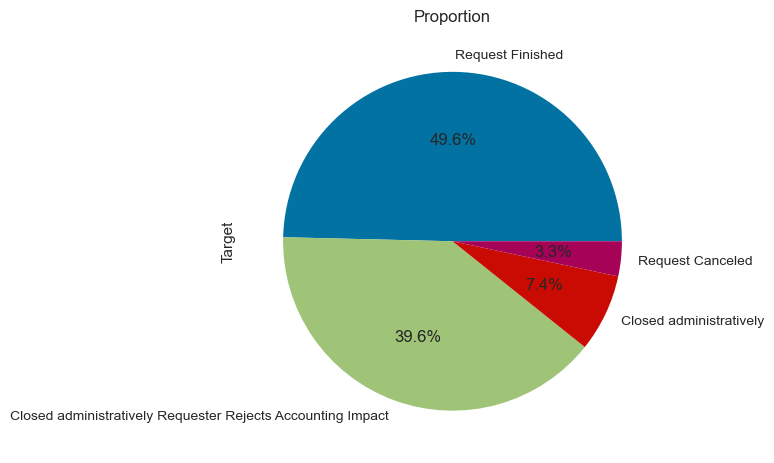

In [294]:
# Data Visualization (Target proportion)
ds_joined.Target.value_counts().plot.pie(autopct = "%.1f%%")
plt.title("Proportion")
plt.show()